In [1]:
# LinkNet with ResNet34 for multiclass semantic segmentation
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 25kB/s 
     |████████████████████████████████| 450kB 47.2MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 3.9MB 37.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=7d29abeeda2a5c7742af5146aec11f3975a503778ab34840361daf81736129c4
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully 

In [ ]:
!pip install segmentation-models

In [3]:
# mount google drive here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Fetch the training, validation and testing dataset
import os
import numpy as np

dataPath  = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/PSPNET'
d = '/content/drive/My Drive/Underwater_Segmentation_Research/Data'

trainPath       =  dataPath + '/Train'
testPath        =  dataPath + '/Test'
valPath         =  d + '/Validate'

trainImgsFile   = 'trainingDataImgs.npy'
trainLabelsFile = 'trainingDataLabels.npy'

testImgsFile    = 'testingDataImgs.npy'
testLabelsFile  = 'testingDataLabels.npy'

valImgsFile     = 'validationDataImgs.npy'
valLabelsFile   = 'validationDataLabels.npy'

def getData(path,fileName):
  return np.load(path + "/" + fileName)
'''
trainImgs   = getData(dataPath, trainImgsFile)
trainLabels = getData(dataPath, trainLabelsFile)

valImgs    = getData(dataPath, valImgsFile)
valLabels  = getData(dataPath, valLabelsFile)

print("Got train and validation data")
print(trainImgs.shape, valImgs.shape)
print(trainLabels.shape, valLabels.shape)
'''

'\ntrainImgs   = getData(dataPath, trainImgsFile)\ntrainLabels = getData(dataPath, trainLabelsFile)\n\nvalImgs    = getData(dataPath, valImgsFile)\nvalLabels  = getData(dataPath, valLabelsFile)\n\nprint("Got train and validation data")\nprint(trainImgs.shape, valImgs.shape)\nprint(trainLabels.shape, valLabels.shape)\n'

In [ ]:
# Create the model (without pre-trained ImageNet weights)
import os
import numpy as np
import tensorflow as tf
import segmentation_models as sm

# create the model
model = sm.PSPNet('resnet18', input_shape=(480, 480, 1), encoder_weights=None, classes=12, activation='softmax')
model.summary()


In [4]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [5]:
import tensorflow as tf
LOSS=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile('Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', UpdatedMeanIoU(num_classes=12)])

In [8]:
# Setup training parameters
BATCH = 16
EPOCHS = 30

# early stopping callback. It stops training when the loss does not change for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [9]:
history = model.fit(trainImgs, trainLabels, epochs=EPOCHS, batch_size=BATCH, validation_data=(valImgs, valLabels))

Train on 1000 samples, validate on 251 samples
Epoch 1/30
1000/1000 [==============================] - 44s 44ms/sample - loss: 0.1499 - accuracy: 0.9627 - updated_mean_io_u: 0.1459 - val_loss: 0.3939 - val_accuracy: 0.9748 - val_updated_mean_io_u: 0.0812
Epoch 2/30
1000/1000 [==============================] - 31s 31ms/sample - loss: 0.0462 - accuracy: 0.9854 - updated_mean_io_u: 0.2975 - val_loss: 0.3957 - val_accuracy: 0.8613 - val_updated_mean_io_u: 0.0941
Epoch 3/30
1000/1000 [==============================] - 32s 32ms/sample - loss: 0.0353 - accuracy: 0.9879 - updated_mean_io_u: 0.4268 - val_loss: 0.0812 - val_accuracy: 0.9808 - val_updated_mean_io_u: 0.1723
Epoch 4/30
1000/1000 [==============================] - 33s 33ms/sample - loss: 0.0299 - accuracy: 0.9893 - updated_mean_io_u: 0.5040 - val_loss: 0.0473 - val_accuracy: 0.9854 - val_updated_mean_io_u: 0.3470
Epoch 5/30
1000/1000 [==============================] - 33s 33ms/sample - loss: 0.0277 - accuracy: 0.9899 - updated_mean_

dict_keys(['loss', 'accuracy', 'updated_mean_io_u', 'val_loss', 'val_accuracy', 'val_updated_mean_io_u'])


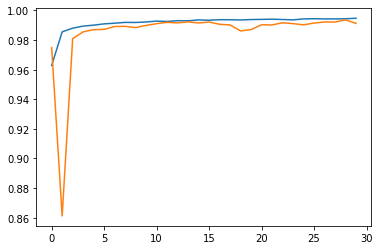

In [10]:
print(history.history.keys())

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

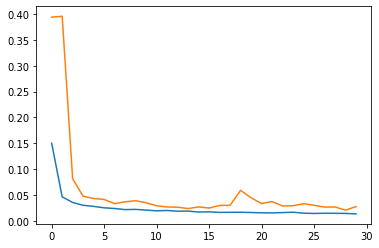

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

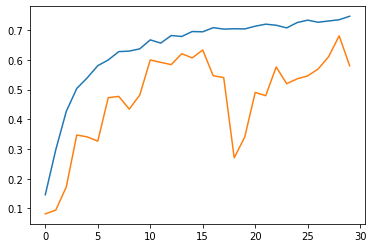

In [13]:
plt.plot(history.history['updated_mean_io_u'])
plt.plot(history.history['val_updated_mean_io_u'])

In [6]:
# get the testdata
testImgs   = getData(dataPath, testImgsFile)
testLabels = getData(dataPath, testLabelsFile)
print(testImgs.shape, testLabels.shape)

(617, 480, 480, 1) (617, 480, 480, 1)


In [15]:
model.evaluate(testImgs, testLabels)

617/617 [==============================] - 9s 15ms/sample - loss: 0.0261 - accuracy: 0.9907 - updated_mean_io_u: 0.5756


[0.026062823089392104, 0.9906523, 0.57560855]

In [9]:
# save the model weights
weightFileName = "PSPResNet18_30e_16b.h5"
weightPath = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/PSPNET'
#model.save_weights(weightPath + "/" + weightFileName)


In [ ]:
model.load_weights(weightPath + "/" + weightFileName)
#model.evaluate(testImgs, testLabels)

In [ ]:
modelFileName = "PSPResNet18_30e_16b"
modelPath     = '/content/drive/My Drive/Underwater_Segmentation_Research/Models/PSPNET'
model.save(modelPath + "/" + modelFileName)

In [18]:
# Check the GPU configuration
!nvidia-smi

Thu May 27 15:26:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   8802MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
y_preds = model.predict(testImgs)
y_preds = (y_preds >= 0.5).astype(np.uint8)

NameError: ignored

In [ ]:
# Compute mean of per-class IOU throughout the test images
num_classes=12
m = UpdatedMeanIoU(num_classes=12)
m.update_state(testLabels, y_preds)

print(f'Overall mean IOU is : {m.result().numpy()}')

# Values is the confusion matrix
values = np.array(m.get_weights()).reshape(num_classes, num_classes)

In [ ]:
yPreds = tf.argmax(ypreds, axis=-1)
yPreds = yPreds.numpy()

In [ ]:
import matplotlib.pyplot as plt
i = 0
plt.imshow(yPreds[i])
plt.show()

print(np.unique(yPreds[i,:,:]))

plt.imshow(testLabels[i,:,:,0])
plt.show()

print(np.unique(testLabels[i,:,:,0]))

t = np.linspace(0,11,num=12)
plt.plot(t, perClassIoU)
plt.show()